In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import torch #design and train neural networks
from torch.utils.data import Dataset, DataLoader #customize dataset, feed data
import torchvision #image to tensors, resize and normalize images
import matplotlib.pyplot as plt #visualize data and nn training progress
from PIL import Image # open load images

# Create PyTorch Dataset Class

In [4]:
class TorchDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.image_paths = [os.path.join(data_path, file) for file in os.listdir(data_path) if file.endswith('.jpg')]
        
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image


# Define Transformations 
* Resize image to 256*256 to unify input dimensions
* Convert to tensors for neural networks
* Normalize the tensor value to be between -1~1 by setting mean=0.5 sd=0.5 (across 3 RGB channels)

In [5]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((256,256)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
root_path = "/kaggle/input/gan-getting-started"
print(os.listdir(root_path))
data_path_monet = f"{root_path}/monet_jpg"
data_path_photo = f"{root_path}/photo_jpg"

['monet_jpg', 'photo_tfrec', 'photo_jpg', 'monet_tfrec']


# DataLoader and Exploratory data analysis

In [22]:
MonetDataset = TorchDataset(data_path=data_path_monet, transform=transforms)
PhotoDataset = TorchDataset(data_path=data_path_photo, transform=transforms)

MonetLoader = DataLoader(MonetDataset, batch_size=16, shuffle=True, num_workers=2)
PhotoLoader = DataLoader(PhotoDataset, batch_size=16, shuffle=True, num_workers=2)

In [36]:
print(len(PhotoDataset), len(MonetDataset))

7038 300


In [24]:
# fetch the next batch(16 images in tensor format) from the two DataLoaders 
monets = next(iter(MonetLoader))
photos = next(iter(PhotoLoader))
print(monets.shape, photos.shape)

torch.Size([16, 3, 256, 256]) torch.Size([16, 3, 256, 256])


In [25]:
print(monets[0].min(), monets[0].max())
print(photos[0].min(), photos[0].max())

tensor(-0.6471) tensor(1.)
tensor(-1.) tensor(1.)


In [26]:
# tansform data to be readable by plt.imshow
monets_imshow = []
for monet in monets:
    monet = monet.permute(1, 2, 0) #tensor[C,H,W] -> imshow[H,W,C] height,weight,channel
    monet = monet.numpy() # tensor -> numpy_arr readable by imshow
    monet = monet * 0.5 + 0.5 # un-normalize the data
    monets_imshow.append(monet)

photos_imshow = []    
for photo in photos:
    photo = photo.permute(1, 2, 0) #tensor[C,H,W] -> imshow[H,W,C] height,weight,channel
    photo = photo.numpy() # tensor -> numpy_arr readable by imshow
    photo = photo * 0.5 + 0.5 # un-normalize the data
    photos_imshow.append(photo)

In [27]:
print(monets_imshow[3].shape)  # Check the shape of one of the images
print(monets_imshow[3].dtype) 

(256, 256, 3)
float32


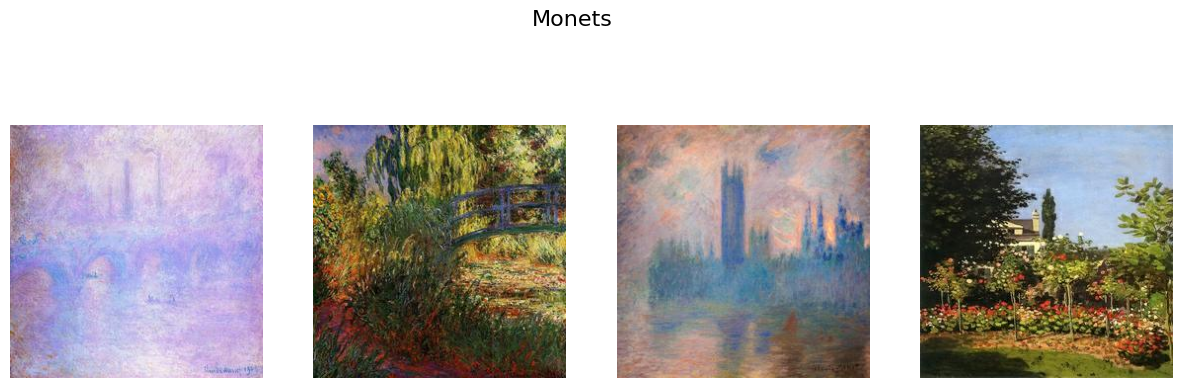

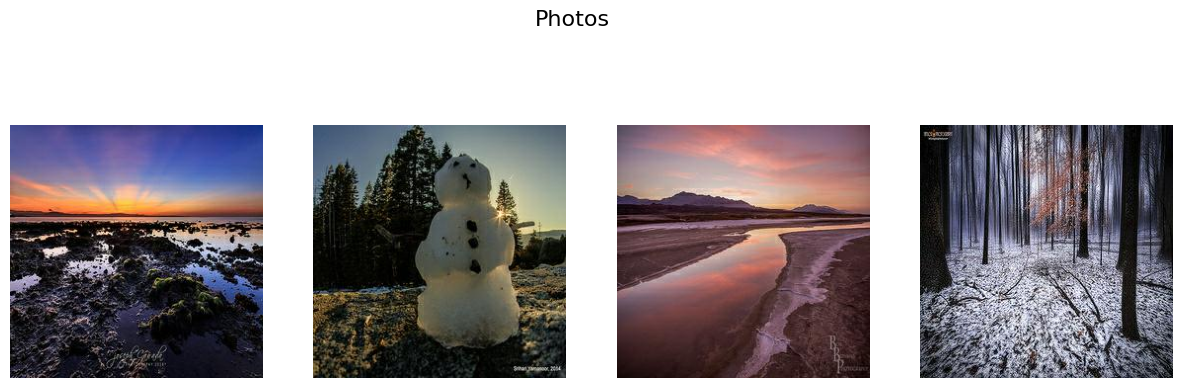

In [28]:
# Monets
fig1 = plt.figure(figsize=(15, 5)) 

plt.subplot(1, 4, 1)  
plt.imshow(monets_imshow[0])
plt.axis('off')  

plt.subplot(1, 4, 2)  
plt.imshow(monets_imshow[1])
plt.axis('off')  

plt.subplot(1, 4, 3)  
plt.imshow(monets_imshow[2])
plt.axis('off')  

plt.subplot(1, 4, 4)  
plt.imshow(monets_imshow[3])
plt.axis('off')  


# Add a title for the entire figure
fig1.suptitle('Monets', fontsize=16)

# Display all the plots
plt.show()




# Photos
fig2 = plt.figure(figsize=(15, 5)) 

plt.subplot(1, 4, 1)  
plt.imshow(photos_imshow[0])
plt.axis('off')  

plt.subplot(1, 4, 2)  
plt.imshow(photos_imshow[1])
plt.axis('off')  

plt.subplot(1, 4, 3)  
plt.imshow(photos_imshow[2])
plt.axis('off')  

plt.subplot(1, 4, 4)  
plt.imshow(photos_imshow[3])
plt.axis('off')  


# Add a title for the entire figure
fig2.suptitle('Photos', fontsize=16)

# Display all the plots
plt.show()

# CycleGAN Model
### Define Block Class
In neural network architecture design, a "block" typically refers to a repeatable and modular unit of layers that perform a set of operations, which can be stacked or repeated with similar or varying parameters to build more complex architectures. The advantage of designing neural networks in blocks includes:
* Reusability: Once defined, blocks can be reused within different parts of the network or in different network architectures.
* Readability and Maintainability: Organizing code into logical units (blocks) makes it easier to manage and understand.
* Modularity: Blocks can be designed, tested, and optimized independently.

In [14]:
import torch.nn as nn

class Block(nn.Module):
    # define states (attributes) -> NN layers
    def __init__(self, in_channels, out_channels, stride):
        # inherent from the parent class -> nn.Module
        super().__init__()
        self.cnn = nn.Sequential(
            # Convolution layer
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=4,
                stride=stride,
                padding=1,
                bias=True,
                padding_mode="reflect", # reflect padding reduces artifact
            ), 
            # Normalization layer -> Instance rather than Batch
            # helps preserve artistic style integrity, 
            # regardless of the variability in content across different images in a batch
            nn.InstanceNorm2d(out_channels), 
            # Activation Func
            nn.LeakyReLU(0.2, inplace=True), 
        )
    
    # define behaviors (methods) -> feed forward 
    def forward(self, x):
        return self.cnn(x)

### Discriminator
* Initial Convolution: The network starts with a convolution layer to process the initial input. This layer uses a stride of 2 to reduce dimensions and applies a leaky ReLU for non-linear activation.

* Blocks: The discriminator sequentially applies several Block instances, each performing a convolution, normalization, and activation. These layers progressively increase the number of channels while reducing the spatial size (depending on the stride).

* Final Convolution: A convolutional layer that maps the deep feature representation to a single output channel.
* Sigmoid Activation: After the final layer, a sigmoid activation function is applied to squish the output to a [0,1] range, indicating the probability of the input being real.

In [15]:
class Discriminator(nn.Module):
    def __init__(self, in_channels=3, features=[64, 128, 256, 512]):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                in_channels,
                features[0],
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
            ),
            nn.LeakyReLU(0.2, inplace=True),
        )

        layers = []
        in_channels = features[0]
        for feature in features[1:]:
            layers.append(
                Block(in_channels, feature, stride=1 if feature == features[-1] else 2)
            )
            in_channels = feature
        layers.append(
            nn.Conv2d(
                in_channels,
                1,
                kernel_size=4,
                stride=1,
                padding=1,
                padding_mode="reflect",
            )
        )
        # * unpack layers list into separate arguments
        # layer in layers forms feed-forward NNs
        self.model = nn.Sequential(*layers)

    
    # define how the input tensor x pass thru the NNs in forward:
    # x -> first pass thru the initial layer defined above
    # -> then thru the model layer(dynamically added based on the features list)
    # -> sigmoid last layer to map output to 0~1 probability (fake~real)
    def forward(self, x):
        x = self.initial(x)
        return torch.sigmoid(self.model(x))

In [16]:
# Test Discriminator

model_dis_test = Discriminator()

# creates random tensor x to simulates a batch of 2 images
test_input = torch.randn((2, 3, 256, 256))

# Forward the test input through the model
print(model_dis_test(test_input).shape)

torch.Size([2, 1, 30, 30])


### Define CNNBlock and ResidualBlock 
* **CNNBlock** is used to build both ***downsampling*** (standard convolution -> reduces the spatial dimensions while increasing feature depth to abstract higher-level features) and ***upsampling*** (transposed convolution -> increases the spatial dimensions while refining features to reconstruct detailed and high-quality images) layers within the Generator.
* **ResidualBlock** adds input of the block to its output, mitigating the vanishing gradient problem ->  important for training deeper networks effectively; and enabling the network to learn identity mappings efficiently -> ensuring that essential information is not lost as data passes through multiple layers of transformations.

In [17]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, down=True, use_act=True, **kwargs):
        super().__init__()
        
        if down:
            conv_layer = nn.Conv2d(in_channels, out_channels, padding_mode="reflect", **kwargs)
        else:
            conv_layer = nn.ConvTranspose2d(in_channels, out_channels, **kwargs)
        
        if use_act:
            act_layer = nn.ReLU(inplace=True)
        else:
            act_layer = nn.Identity()
        
        self.cnn = nn.Sequential(
            conv_layer,
            nn.InstanceNorm2d(out_channels),
            act_layer,
        )

    def forward(self, x):
        return self.cnn(x)


class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            CNNBlock(channels, channels, kernel_size=3, padding=1),
            CNNBlock(channels, channels, use_act=False, kernel_size=3, padding=1),
        )

    def forward(self, x):
        return x + self.block(x)

### Generator
* Initial Convolution: Processes the initial input to expand the feature space without changing spatial dimensions, using a 7x7 kernel size with a stride of 1 and padding set to 3. 
* Downsampling Blocks: Reduces the spatial dimensions while increasing the feature depth, using multiple CNNBlock instances each with a stride of 2. Halve dimensions and double feature channels.
* Residual Blocks: Use multiple ResidualBlock instances to enhances feature representations without altering their spatial dimensions.
* Upsampling Blocks: Restores the spatial dimensions to match the original input size while refining features, ussing CNNBlock instances configured for upsampling through transposed convolution. 
* Final Convolution: Reconstructs the final image from the refined feature maps, employing a large 7x7 convolutional layer to ensure detailed spatial capture. Use tanh activation function to map output to [-1,1]

In [18]:
class Generator(nn.Module):
    def __init__(self, img_channels, num_features=64, num_residuals=9):
        super().__init__()
        self.initial = nn.Sequential(
            nn.Conv2d(
                img_channels,
                num_features,
                kernel_size=7,
                stride=1,
                padding=3,
                padding_mode="reflect",
            ),
            nn.InstanceNorm2d(num_features),
            nn.ReLU(inplace=True),
        )
        self.down_blocks = nn.ModuleList(
            [
                CNNBlock(
                    num_features, 
                    num_features * 2, 
                    kernel_size=3, 
                    stride=2, 
                    padding=1
                ),
                CNNBlock(
                    num_features * 2,
                    num_features * 4,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                ),
            ]
        )
        self.res_blocks = nn.Sequential(
            *[ResidualBlock(num_features * 4) for _ in range(num_residuals)]
        )
        self.up_blocks = nn.ModuleList(
            [
                CNNBlock(
                    num_features * 4,
                    num_features * 2,
                    down=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
                CNNBlock(
                    num_features * 2,
                    num_features * 1,
                    down=False,
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                ),
            ]
        )

        self.last = nn.Conv2d(
            num_features * 1,
            img_channels,
            kernel_size=7,
            stride=1,
            padding=3,
            padding_mode="reflect",
        )

    def forward(self, x):
        x = self.initial(x)
        for layer in self.down_blocks:
            x = layer(x)
        x = self.res_blocks(x)
        for layer in self.up_blocks:
            x = layer(x)
        return torch.tanh(self.last(x))

In [19]:
# Test Generator 

img_channels = 3
img_size = 256
# creates random tensor x to simulates a batch of 2 images
test_input = torch.randn((2, img_channels, img_size, img_size))

model_gen_test = Generator(img_channels, 9)

# Forward the test input through the model
print(model_gen_test(test_input).shape)

torch.Size([2, 3, 256, 256])


In [20]:
# Check for available device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [29]:
from torch.utils.data import random_split

# Define the size of the validation set
val_size_monet = int(0.2 * len(MonetDataset))
train_size_monet = len(MonetDataset) - val_size_monet

val_size_photo = int(0.2 * len(PhotoDataset))
train_size_photo = len(PhotoDataset) - val_size_photo


# Split datasets into training and validation
train_MonetDataset, val_MonetDataset = random_split(MonetDataset, [train_size_monet, val_size_monet])
train_PhotoDataset, val_PhotoDataset = random_split(PhotoDataset, [train_size_photo, val_size_photo])

# Create data loaders for training and validation datasets
train_MonetLoader = DataLoader(train_MonetDataset, batch_size=16, shuffle=True, num_workers=2)
val_MonetLoader = DataLoader(val_MonetDataset, batch_size=16, shuffle=False, num_workers=2)

train_PhotoLoader = DataLoader(train_PhotoDataset, batch_size=16, shuffle=True, num_workers=2)
val_PhotoLoader = DataLoader(val_PhotoDataset, batch_size=16, shuffle=False, num_workers=2)

# Training

Epoch [1/30] - loss_G_Photo2Monet: 0.1201, loss_G_Monet2Photo: 2.4368, loss_D_Photo: 0.0101, loss_D_Monet: 0.2433
Epoch [2/30] - loss_G_Photo2Monet: 0.1154, loss_G_Monet2Photo: 2.2827, loss_D_Photo: 0.0092, loss_D_Monet: 0.2342
Epoch [3/30] - loss_G_Photo2Monet: 0.1148, loss_G_Monet2Photo: 2.2024, loss_D_Photo: 0.0090, loss_D_Monet: 0.2313
Epoch [4/30] - loss_G_Photo2Monet: 0.1070, loss_G_Monet2Photo: 2.1567, loss_D_Photo: 0.0085, loss_D_Monet: 0.2280
Epoch [5/30] - loss_G_Photo2Monet: 0.1093, loss_G_Monet2Photo: 2.0191, loss_D_Photo: 0.0087, loss_D_Monet: 0.2351


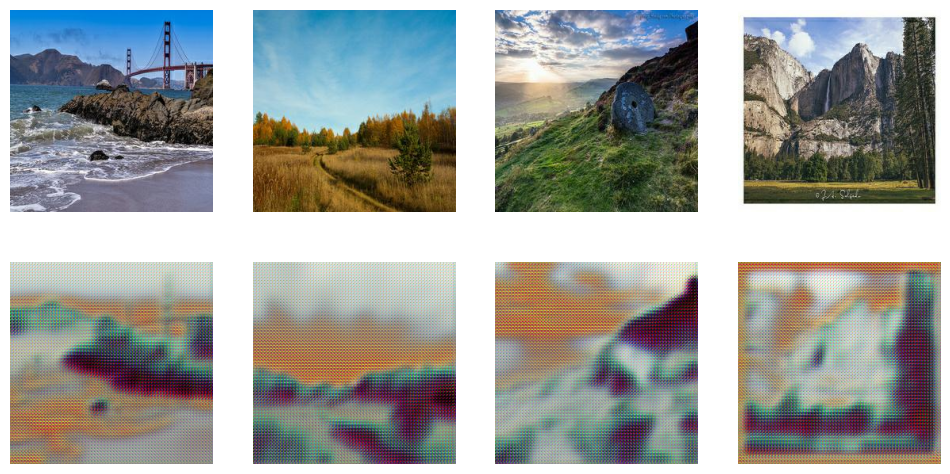

Epoch [6/30] - loss_G_Photo2Monet: 0.1088, loss_G_Monet2Photo: 2.0514, loss_D_Photo: 0.0080, loss_D_Monet: 0.2220
Epoch [7/30] - loss_G_Photo2Monet: 0.1136, loss_G_Monet2Photo: 2.2303, loss_D_Photo: 0.0081, loss_D_Monet: 0.2204
Epoch [8/30] - loss_G_Photo2Monet: 0.1204, loss_G_Monet2Photo: 2.3324, loss_D_Photo: 0.0074, loss_D_Monet: 0.2058
Epoch [9/30] - loss_G_Photo2Monet: 0.1145, loss_G_Monet2Photo: 2.4445, loss_D_Photo: 0.0068, loss_D_Monet: 0.1859
Epoch [10/30] - loss_G_Photo2Monet: 0.1173, loss_G_Monet2Photo: 2.5051, loss_D_Photo: 0.0070, loss_D_Monet: 0.1835


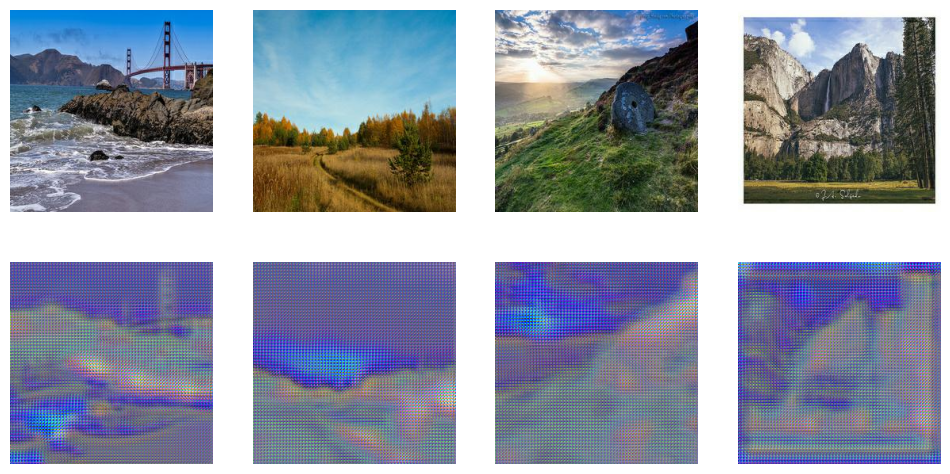

Epoch [11/30] - loss_G_Photo2Monet: 0.1155, loss_G_Monet2Photo: 2.3781, loss_D_Photo: 0.0069, loss_D_Monet: 0.1997
Epoch [12/30] - loss_G_Photo2Monet: 0.1042, loss_G_Monet2Photo: 2.1669, loss_D_Photo: 0.0077, loss_D_Monet: 0.2492
Epoch [13/30] - loss_G_Photo2Monet: 0.1005, loss_G_Monet2Photo: 2.1768, loss_D_Photo: 0.0082, loss_D_Monet: 0.2321
Epoch [14/30] - loss_G_Photo2Monet: 0.0877, loss_G_Monet2Photo: 2.0845, loss_D_Photo: 0.0098, loss_D_Monet: 0.2355
Epoch [15/30] - loss_G_Photo2Monet: 0.0917, loss_G_Monet2Photo: 1.9190, loss_D_Photo: 0.0105, loss_D_Monet: 0.2234


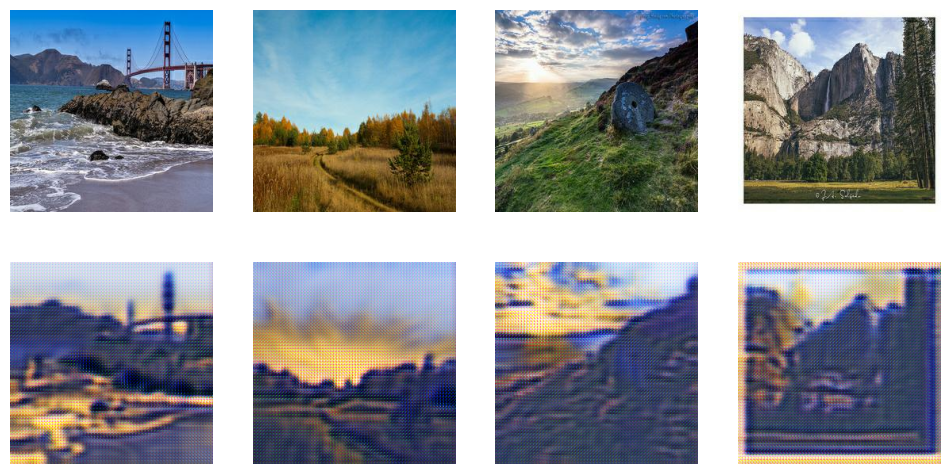

Epoch [16/30] - loss_G_Photo2Monet: 0.0903, loss_G_Monet2Photo: 1.8656, loss_D_Photo: 0.0097, loss_D_Monet: 0.2358
Epoch [17/30] - loss_G_Photo2Monet: 0.0876, loss_G_Monet2Photo: 1.8997, loss_D_Photo: 0.0096, loss_D_Monet: 0.2397
Epoch [18/30] - loss_G_Photo2Monet: 0.0915, loss_G_Monet2Photo: 1.8988, loss_D_Photo: 0.0084, loss_D_Monet: 0.2236
Epoch [19/30] - loss_G_Photo2Monet: 0.0809, loss_G_Monet2Photo: 1.8688, loss_D_Photo: 0.0091, loss_D_Monet: 0.2324
Epoch [20/30] - loss_G_Photo2Monet: 0.0825, loss_G_Monet2Photo: 1.8231, loss_D_Photo: 0.0091, loss_D_Monet: 0.2237


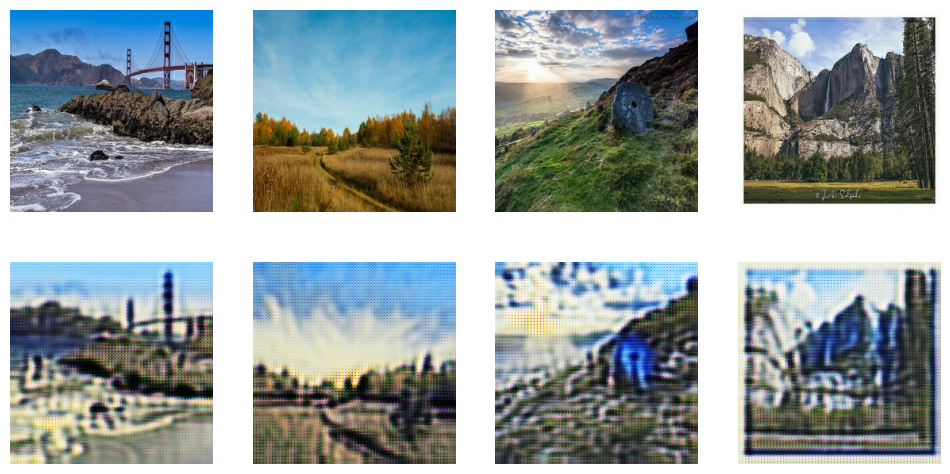

Epoch [21/30] - loss_G_Photo2Monet: 0.0852, loss_G_Monet2Photo: 1.8235, loss_D_Photo: 0.0091, loss_D_Monet: 0.2164
Epoch [22/30] - loss_G_Photo2Monet: 0.0781, loss_G_Monet2Photo: 1.8004, loss_D_Photo: 0.0091, loss_D_Monet: 0.2192
Epoch [23/30] - loss_G_Photo2Monet: 0.0771, loss_G_Monet2Photo: 1.7785, loss_D_Photo: 0.0090, loss_D_Monet: 0.2134
Epoch [24/30] - loss_G_Photo2Monet: 0.0792, loss_G_Monet2Photo: 1.8159, loss_D_Photo: 0.0088, loss_D_Monet: 0.2087
Epoch [25/30] - loss_G_Photo2Monet: 0.0768, loss_G_Monet2Photo: 1.7917, loss_D_Photo: 0.0086, loss_D_Monet: 0.2094


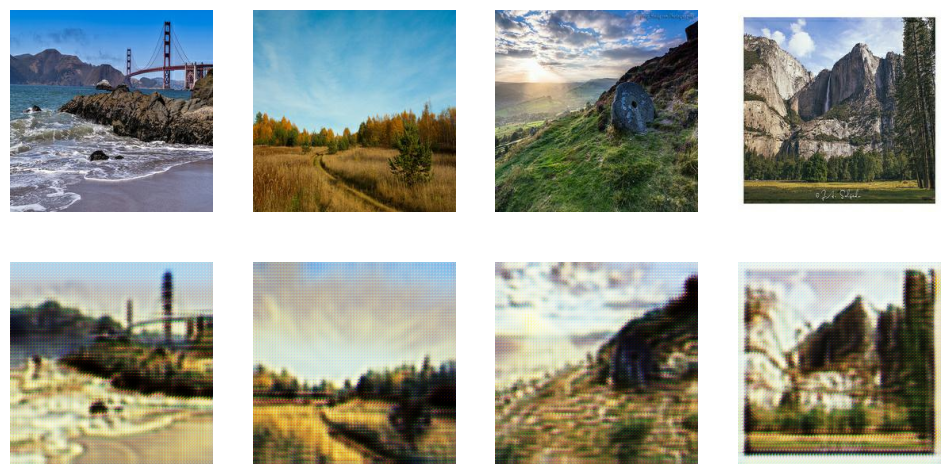

Epoch [26/30] - loss_G_Photo2Monet: 0.0804, loss_G_Monet2Photo: 1.7627, loss_D_Photo: 0.0084, loss_D_Monet: 0.2005
Epoch [27/30] - loss_G_Photo2Monet: 0.0766, loss_G_Monet2Photo: 1.9239, loss_D_Photo: 0.0092, loss_D_Monet: 0.2050
Epoch [28/30] - loss_G_Photo2Monet: 0.0812, loss_G_Monet2Photo: 1.9611, loss_D_Photo: 0.0075, loss_D_Monet: 0.1770
Epoch [29/30] - loss_G_Photo2Monet: 0.0806, loss_G_Monet2Photo: 1.9017, loss_D_Photo: 0.0103, loss_D_Monet: 0.1829
Epoch [30/30] - loss_G_Photo2Monet: 0.0848, loss_G_Monet2Photo: 1.7815, loss_D_Photo: 0.0103, loss_D_Monet: 0.1934


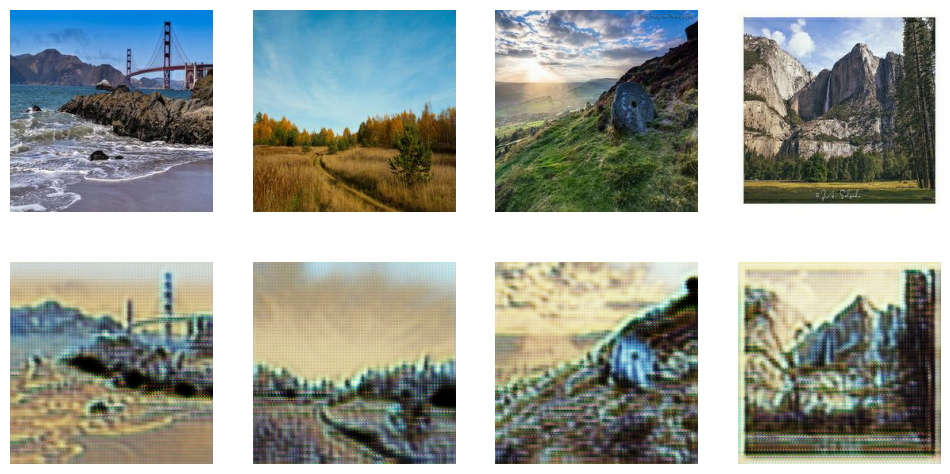

In [30]:
import torch.optim as optim
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm


# Initialize models
device = "cuda" if torch.cuda.is_available() else "cpu"
G_Photo2Monet = Generator(img_channels=3).to(device)
G_Monet2Photo = Generator(img_channels=3).to(device)
D_Photo = Discriminator(in_channels=3).to(device)
D_Monet = Discriminator(in_channels=3).to(device)

# Initialize optimizers
optimizer_G_Photo2Monet = optim.Adam(G_Photo2Monet.parameters(), lr=1e-4, betas=(0.5, 0.5))
optimizer_G_Monet2Photo = optim.Adam(G_Monet2Photo.parameters(), lr=1e-4, betas=(0.5, 0.5))
optimizer_D_Photo = optim.Adam(D_Photo.parameters(), lr=1e-4, betas=(0.5, 0.5))
optimizer_D_Monet = optim.Adam(D_Monet.parameters(), lr=1e-4, betas=(0.5, 0.5))

# Loss functions
criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()

# Mixed precision training
scaler = GradScaler()

# Hyperparameters
lambda_cycle = 5
num_epochs = 160
batch_size = 16


# Training loop
for epoch in range(num_epochs):
    epoch_loss_G_Photo2Monet = 0
    epoch_loss_G_Monet2Photo = 0
    epoch_loss_D_Photo = 0
    epoch_loss_D_Monet = 0
    
    for i, (real_photo, real_monet) in enumerate(zip(train_PhotoLoader, train_MonetLoader)):
        real_photo = real_photo.to(device)
        real_monet = real_monet.to(device)
        batch_size = real_photo.size(0)

        # Generate fake images
        fake_monet = G_Photo2Monet(real_photo).detach()
        fake_photo = G_Monet2Photo(real_monet).detach()

        # Get discriminator output sizes
        D_Photo_real = D_Photo(real_photo)
        D_Monet_real = D_Monet(real_monet)
        D_Photo_output_shape = D_Photo_real.shape
        D_Monet_output_shape = D_Monet_real.shape

        # Create labels with the correct shape
        real_label_Photo = torch.ones(D_Photo_output_shape, dtype=torch.float, device=device)
        fake_label_Photo = torch.zeros(D_Photo_output_shape, dtype=torch.float, device=device)
        real_label_Monet = torch.ones(D_Monet_output_shape, dtype=torch.float, device=device)
        fake_label_Monet = torch.zeros(D_Monet_output_shape, dtype=torch.float, device=device)

        # ----------------------
        # Train Discriminators
        # ----------------------

        with autocast():
            # Discriminator D_Photo
            D_Photo_real = D_Photo(real_photo)
            D_Photo_fake = D_Photo(fake_photo)
            loss_D_Photo_real = criterion_GAN(D_Photo_real, real_label_Photo)
            loss_D_Photo_fake = criterion_GAN(D_Photo_fake, fake_label_Photo)
            loss_D_Photo = (loss_D_Photo_real + loss_D_Photo_fake) * 0.5

            # Discriminator D_Monet
            D_Monet_real = D_Monet(real_monet)
            D_Monet_fake = D_Monet(fake_monet)
            loss_D_Monet_real = criterion_GAN(D_Monet_real, real_label_Monet)
            loss_D_Monet_fake = criterion_GAN(D_Monet_fake, fake_label_Monet)
            loss_D_Monet = (loss_D_Monet_real + loss_D_Monet_fake) * 0.5

        optimizer_D_Photo.zero_grad()
        scaler.scale(loss_D_Photo).backward()
        scaler.step(optimizer_D_Photo)

        optimizer_D_Monet.zero_grad()
        scaler.scale(loss_D_Monet).backward()
        scaler.step(optimizer_D_Monet)

        # Accumulate discriminator loss
        epoch_loss_D_Photo += loss_D_Photo.item()
        epoch_loss_D_Monet += loss_D_Monet.item()

        # ----------------------
        # Train Generators
        # ----------------------

        with autocast():
            # GAN loss
            fake_monet = G_Photo2Monet(real_photo)
            fake_photo = G_Monet2Photo(real_monet)
            loss_GAN_Photo2Monet = criterion_GAN(D_Monet(fake_monet), real_label_Monet)
            loss_GAN_Monet2Photo = criterion_GAN(D_Photo(fake_photo), real_label_Photo)

            # Cycle loss
            cycle_photo = G_Monet2Photo(fake_monet)
            cycle_monet = G_Photo2Monet(fake_photo)
            loss_cycle_photo = criterion_cycle(cycle_photo, real_photo)
            loss_cycle_monet = criterion_cycle(cycle_monet, real_monet)

            # Total generator loss
            loss_G_Photo2Monet = loss_GAN_Photo2Monet + lambda_cycle * loss_cycle_photo
            loss_G_Monet2Photo = loss_GAN_Monet2Photo + lambda_cycle * loss_cycle_monet

        optimizer_G_Photo2Monet.zero_grad()
        scaler.scale(loss_G_Photo2Monet).backward()
        scaler.step(optimizer_G_Photo2Monet)

        optimizer_G_Monet2Photo.zero_grad()
        scaler.scale(loss_G_Monet2Photo).backward()
        scaler.step(optimizer_G_Monet2Photo)

        scaler.update()

        # Accumulate generator loss
        epoch_loss_G_Photo2Monet += loss_G_Photo2Monet.item()
        epoch_loss_G_Monet2Photo += loss_G_Monet2Photo.item()

    # Calculate average losses for the epoch
    epoch_loss_G_Photo2Monet /= len(train_PhotoLoader)
    epoch_loss_G_Monet2Photo /= len(train_MonetLoader)
    epoch_loss_D_Photo /= len(train_PhotoLoader)
    epoch_loss_D_Monet /= len(train_MonetLoader)

    print(f"Epoch [{epoch+1}/{num_epochs}] - "
          f"loss_G_Photo2Monet: {epoch_loss_G_Photo2Monet:.4f}, "
          f"loss_G_Monet2Photo: {epoch_loss_G_Monet2Photo:.4f}, "
          f"loss_D_Photo: {epoch_loss_D_Photo:.4f}, "
          f"loss_D_Monet: {epoch_loss_D_Monet:.4f}")

    # Validation and display results every 10 epochs
    if (epoch + 1) % 10 == 0:
        with torch.no_grad():
            G_Photo2Monet.eval()
            example_photo = next(iter(val_PhotoLoader)).to(device)
            fake_monet = G_Photo2Monet(example_photo)

            # Display images
            plt.figure(figsize=(12, 6))
            for i in range(4):
                plt.subplot(2, 4, i + 1)
                plt.imshow(((example_photo[i].cpu().numpy().transpose(1, 2, 0) + 1) / 2))
                plt.axis('off')
                plt.subplot(2, 4, i + 5)
                plt.imshow(((fake_monet[i].cpu().numpy().transpose(1, 2, 0) + 1) / 2))
                plt.axis('off')
            plt.show()

            G_Photo2Monet.train()

# Save final model
final_model_path = 'final_model.pth'
torch.save({
    'G_Photo2Monet': G_Photo2Monet.state_dict(),
    'G_Monet2Photo': G_Monet2Photo.state_dict(),
    'D_Photo': D_Photo.state_dict(),
    'D_Monet': D_Monet.state_dict(),
    'optimizer_G_Photo2Monet': optimizer_G_Photo2Monet.state_dict(),
    'optimizer_G_Monet2Photo': optimizer_G_Monet2Photo.state_dict(),
    'optimizer_D_Photo': optimizer_D_Photo.state_dict(),
    'optimizer_D_Monet': optimizer_D_Monet.state_dict(),
}, final_model_path)

# Inferencing 

In [38]:
import shutil
from zipfile import ZipFile

# Load the trained model
device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = '/kaggle/working/final_model.pth'
checkpoint = torch.load(model_path)


G_Photo2Monet = Generator(img_channels=3).to(device)
G_Photo2Monet.load_state_dict(checkpoint['G_Photo2Monet'])
G_Photo2Monet.eval()

test_loader = DataLoader(PhotoDataset, batch_size=1, shuffle=False)


# Create a directory to save the generated images
os.makedirs('../tmp/images', exist_ok=True)

# Generate Monet-style images and save them
with torch.no_grad():
    for i, img in enumerate(test_loader):
        img = img.to(device)
        fake_monet = G_Photo2Monet(img)[0].cpu().permute(1, 2, 0).numpy() * 0.5 + 0.5
        im = Image.fromarray((fake_monet * 255).astype(np.uint8))
        im.save(f"../tmp/images/{i}.jpg")

# Zip the generated images
output_zip_path = "/kaggle/working/images.zip"
with ZipFile(output_zip_path, 'w') as zipf:
    for root, _, files in os.walk('../tmp/images'):
        for file in files:
            zipf.write(os.path.join(root, file), os.path.relpath(os.path.join(root, file), '../tmp/images'))

print(f"Submission file created at {output_zip_path}")

KeyboardInterrupt: 